# Notebook to analyze latent space of UKBioBank, when trained with all subjects of UKBioBank

In [1]:
import umap
import math
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import DictionaryLearning
from scipy.stats import binom_test

import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict

from contrastive.evaluation.train_multiple_classifiers import compute_auc

INFO: you cannot use deep_folding in brainvisa. Probably OK.


/volatile/jc225751/Runs/59_analysis_ukbiobank/Program/2023_agaudin_jchavas_folding_supervised/contrastive/evaluation/train_multiple_classifiers.py:495: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_name='config_no_save', config_path="../configs")


In [2]:
# test model
test_model = "/volatile/jc225751/Runs/59_analysis_ukbiobank/Output/trained_on_ukbiobank/chosen_model/chosen_model"
# test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#2"
dataset_train = 'cingulate_UkBioBank_full'

# load the data
train_df = pd.read_csv(test_model+'/'+dataset_train+'_embeddings/train_val_embeddings.csv', index_col=0)
train_df.sort_index(inplace=True)
len(train_df)

21070

In [44]:
dataset_test = 'cingulate_UkBioBank_full'

test_df = pd.read_csv(test_model+'/'+dataset_test+'_embeddings/cross_val_effective_embeddings.csv', index_col=0)
test_df.sort_index(inplace=True)


In [45]:
test_df.head()

dim1       dim2       dim3       dim4      dim5       dim6   
ID                                                                             
sub-1000021 -11.076596  -0.057595  -0.504944  13.787151 -5.623169 -14.787988  \
sub-1000458   9.511126   0.128145   4.478192   3.851682  7.315600   7.109015   
sub-1000575 -17.447620  -4.579595 -10.238688  14.008759  5.279232  -0.996238   
sub-1000606   0.840572  15.780233  -9.238464  -0.624598 -5.837039 -27.161880   
sub-1000963  -8.784658   1.427980  -2.758446  -6.381389 -0.388595  13.868286   

                  dim7       dim8       dim9      dim10  
ID                                                       
sub-1000021  -6.232752  15.323558  10.418934 -11.061040  
sub-1000458 -11.019068  -1.318155   1.013750  -4.718797  
sub-1000575   9.278101   0.155234   0.313623  15.755117  
sub-1000606  12.402494   8.603504  13.773625  -3.677514  
sub-1000963 -14.848120   3.806090   4.268199   5.453033

In [4]:
dataset_second = 'cingulate_HCP_full_Flanker_AgeAdj'
second_df = pd.read_csv(test_model+'/'+dataset_second+'_embeddings/cross_val_effective_embeddings.csv', index_col=0)
second_df.sort_index(inplace=True)


# load the labels
prediction_df = pd.read_csv(test_model+'/'+dataset_second+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
prediction_df.sort_index(inplace=True)
len(prediction_df)

1113

In [5]:
dataset_third = 'cingulate_HCP_full_gender'
third_df = pd.read_csv(test_model+'/'+dataset_third+'_embeddings/cross_val_effective_embeddings.csv', index_col=0)
third_df.sort_index(inplace=True)

In [6]:
prediction_df.head()

label     svm_0     svm_1   svm_2     svm_3     svm_4     svm_5   
Subject                                                                    
100206       1  0.483495  0.454635  0.5000  0.484320  0.449744  0.515172  \
100307       0  0.500000  0.507952  0.5000  0.500000  0.505777  0.494354   
100408       1  0.500000  0.509637  0.5000  0.500000  0.507550  0.493698   
100610       1  0.515376  0.547787  0.4943  0.514483  0.547685  0.478817   
101006       0  0.500000  0.500000  0.5000  0.500000  0.500000  0.500000   

            svm_6  svm_7     svm_8  ...   svm_243   svm_244   svm_245   
Subject                             ...                                 
100206   0.472604    0.5  0.500000  ...  0.466311  0.475677  0.478329  \
100307   0.500000    0.5  0.500000  ...  0.505666  0.500000  0.500000   
100408   0.500000    0.5  0.500000  ...  0.506908  0.500000  0.500000   
100610   0.527232    0.5  0.492414  ...  0.535058  0.524683  0.523092   
101006   0.500000    0.5  0.500000  ...  0.500000  0.500000  0.500000   

          svm_246   svm_247   svm_248   svm_249  median_pred  mean_pred   
Subject                                                                   
100206   0.488428  0.483374  0.508773  0.505824          0.5   0.498035  \
100307   0.500000  0.500000  0.500000  0.500000          0.5   0.499307   
100408   0.500000  0.500000  0.500000  0.500000          0.5   0.499152   
100610   0.510543  0.514897  0.487861  0.490785          0.5   0.499560   
101006   0.500000  0.500000  0.500000  0.500000          0.5   0.499811   

         average_model  
Subject                 
100206        0.506338  
100307        0.500000  
100408        0.500000  
100610        0.490929  
101006        0.500000  

[5 rows x 254 columns]

# Analysis latent space

In [39]:
def visualize_each_variable(model_path, display: str, display_err: bool, normalize=True, verbose=False, dataset='cingulate_ACCpatterns'):
    '''
    display: str -> takes the values '0', '1', 'all'
    '''
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Chooses to display only labels '0', '1' or all
    if display == '0':
        full_df = full_df[full_df.label == 0]
    elif display == '1':
        full_df = full_df[full_df.label == 1]
    
    # Some prints if verbose true
    if verbose:
        print("Prediction df:")
        print(prediction_df.iloc[:2, :2])
        print(len(prediction_df))
        print(prediction_df[['label']].shape)
        print("Data df:")
        print(len(data_df))
        print(data_df.iloc[:2, :2])
        print(data_df.shape)
        print("Full df:")
        print(len(full_df))
        print(full_df.iloc[:2, :2])
        print(full_df.shape)

    N, D = full_df.shape
    D = D-1 # There is the label column added

    # Initializes plot
    plt.figure(figsize=(12,8))

    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, N, axis=0)

    # Replaces labels 0, 1 with colors
    label_df = full_df[['label']].copy()
    label_df['label'] = label_df['label'].astype("str")
    label_df['label'] = label_df['label'].replace('0', 'b')
    label_df['label'] = label_df['label'].replace('1', 'r')

    # Builds colors to match pyplot requirements
    colors = label_df['label'].values
    colors = np.reshape(colors, (1,N))
    colors = np.repeat(colors, D, axis=0)
    colors = colors.T
    print('x, full_df and colors shapes: ', x.shape, full_df.shape, colors.shape)
    colors = np.reshape(colors, (N*D,))

    # latent (doesn't take the first column, which is the label)
    latent_df = full_df.iloc[:,1:]
    mu = latent_df.mean()
    std = latent_df.std()
    if normalize == True:
        latent_df = (latent_df-mu)/std

    # Actual plotting of each point
    plt.scatter(x, latent_df, c=colors, marker='.')

    # Computes averages
    if display == "all":
        # Computes average for label=0
        x = np.arange(D)
        label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
        if normalize == True:   
            label0_df = (label0_df-mu)/std
        mean_df = label0_df.mean()
        e_df = label0_df.std()
        print(x.shape, mean_df.shape, e_df.shape)
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='blue', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3, solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

        # Computes average for label=1
        label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
        if normalize == True:   
            label1_df = (label1_df-mu)/std
        mean_df = label1_df.mean()
        e_df = label1_df.std()
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='red', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3,solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    # Shows the computed plot
    plt.show()

    return 

x, full_df and colors shapes:  (341, 10) (341, 11) (341, 10)
(10,) (10,) (10,)


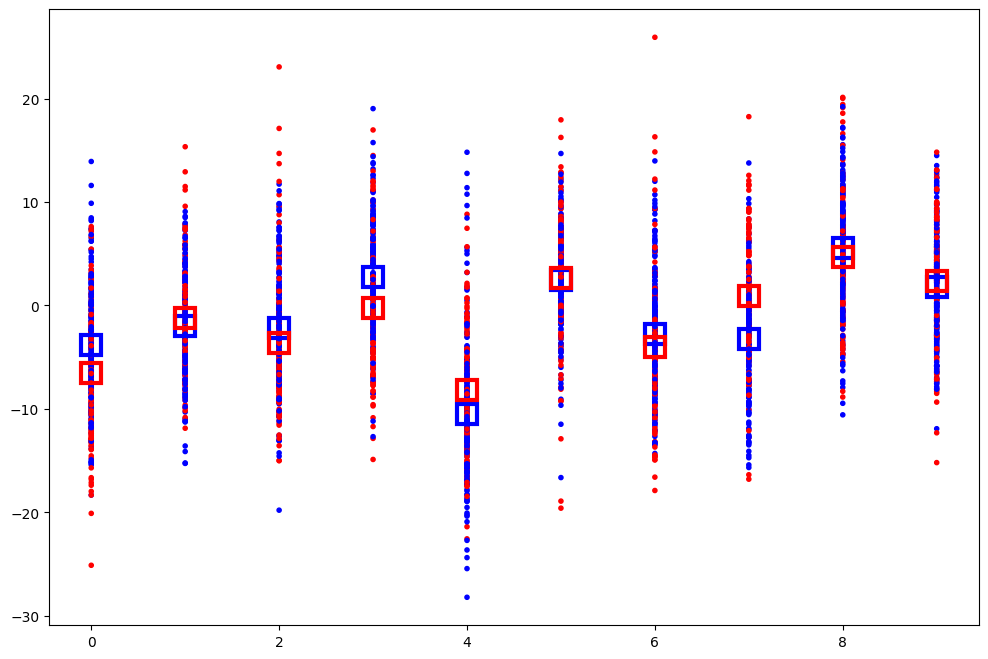

In [40]:
visualize_each_variable(test_model, display='all', display_err=False, normalize=False, verbose=False, dataset='cingulate_ACCpatterns')

x, full_df and colors shapes:  (21070, 10) (21070, 11) (21070, 10)
(10,) (10,) (10,)


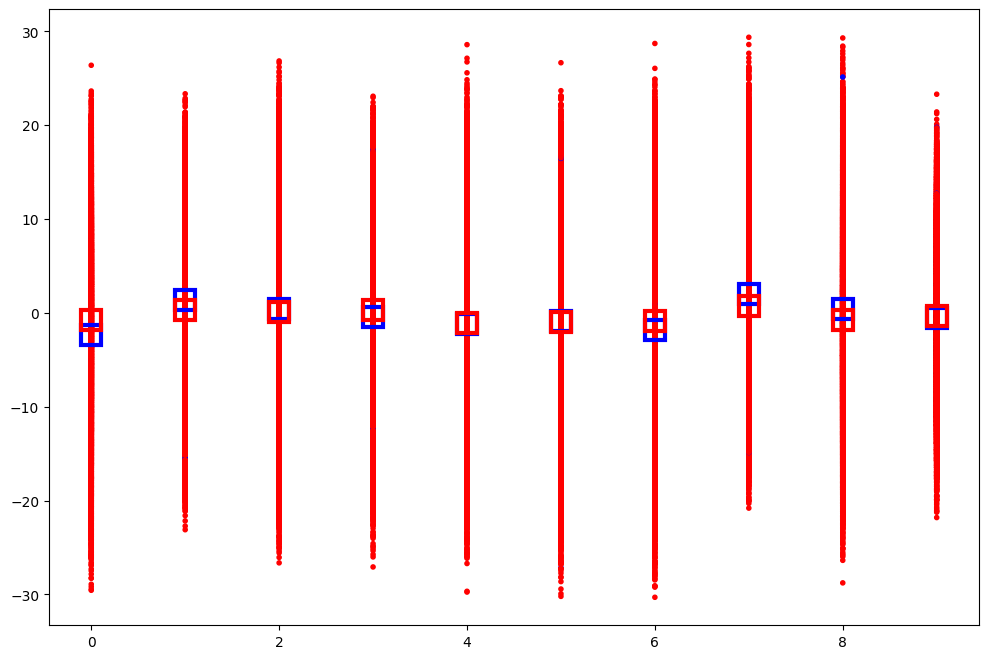

In [42]:
visualize_each_variable(test_model, display='all', display_err=False, normalize=False, verbose=False, dataset='cingulate_UkBioBank_full')

In [43]:
import seaborn as sns

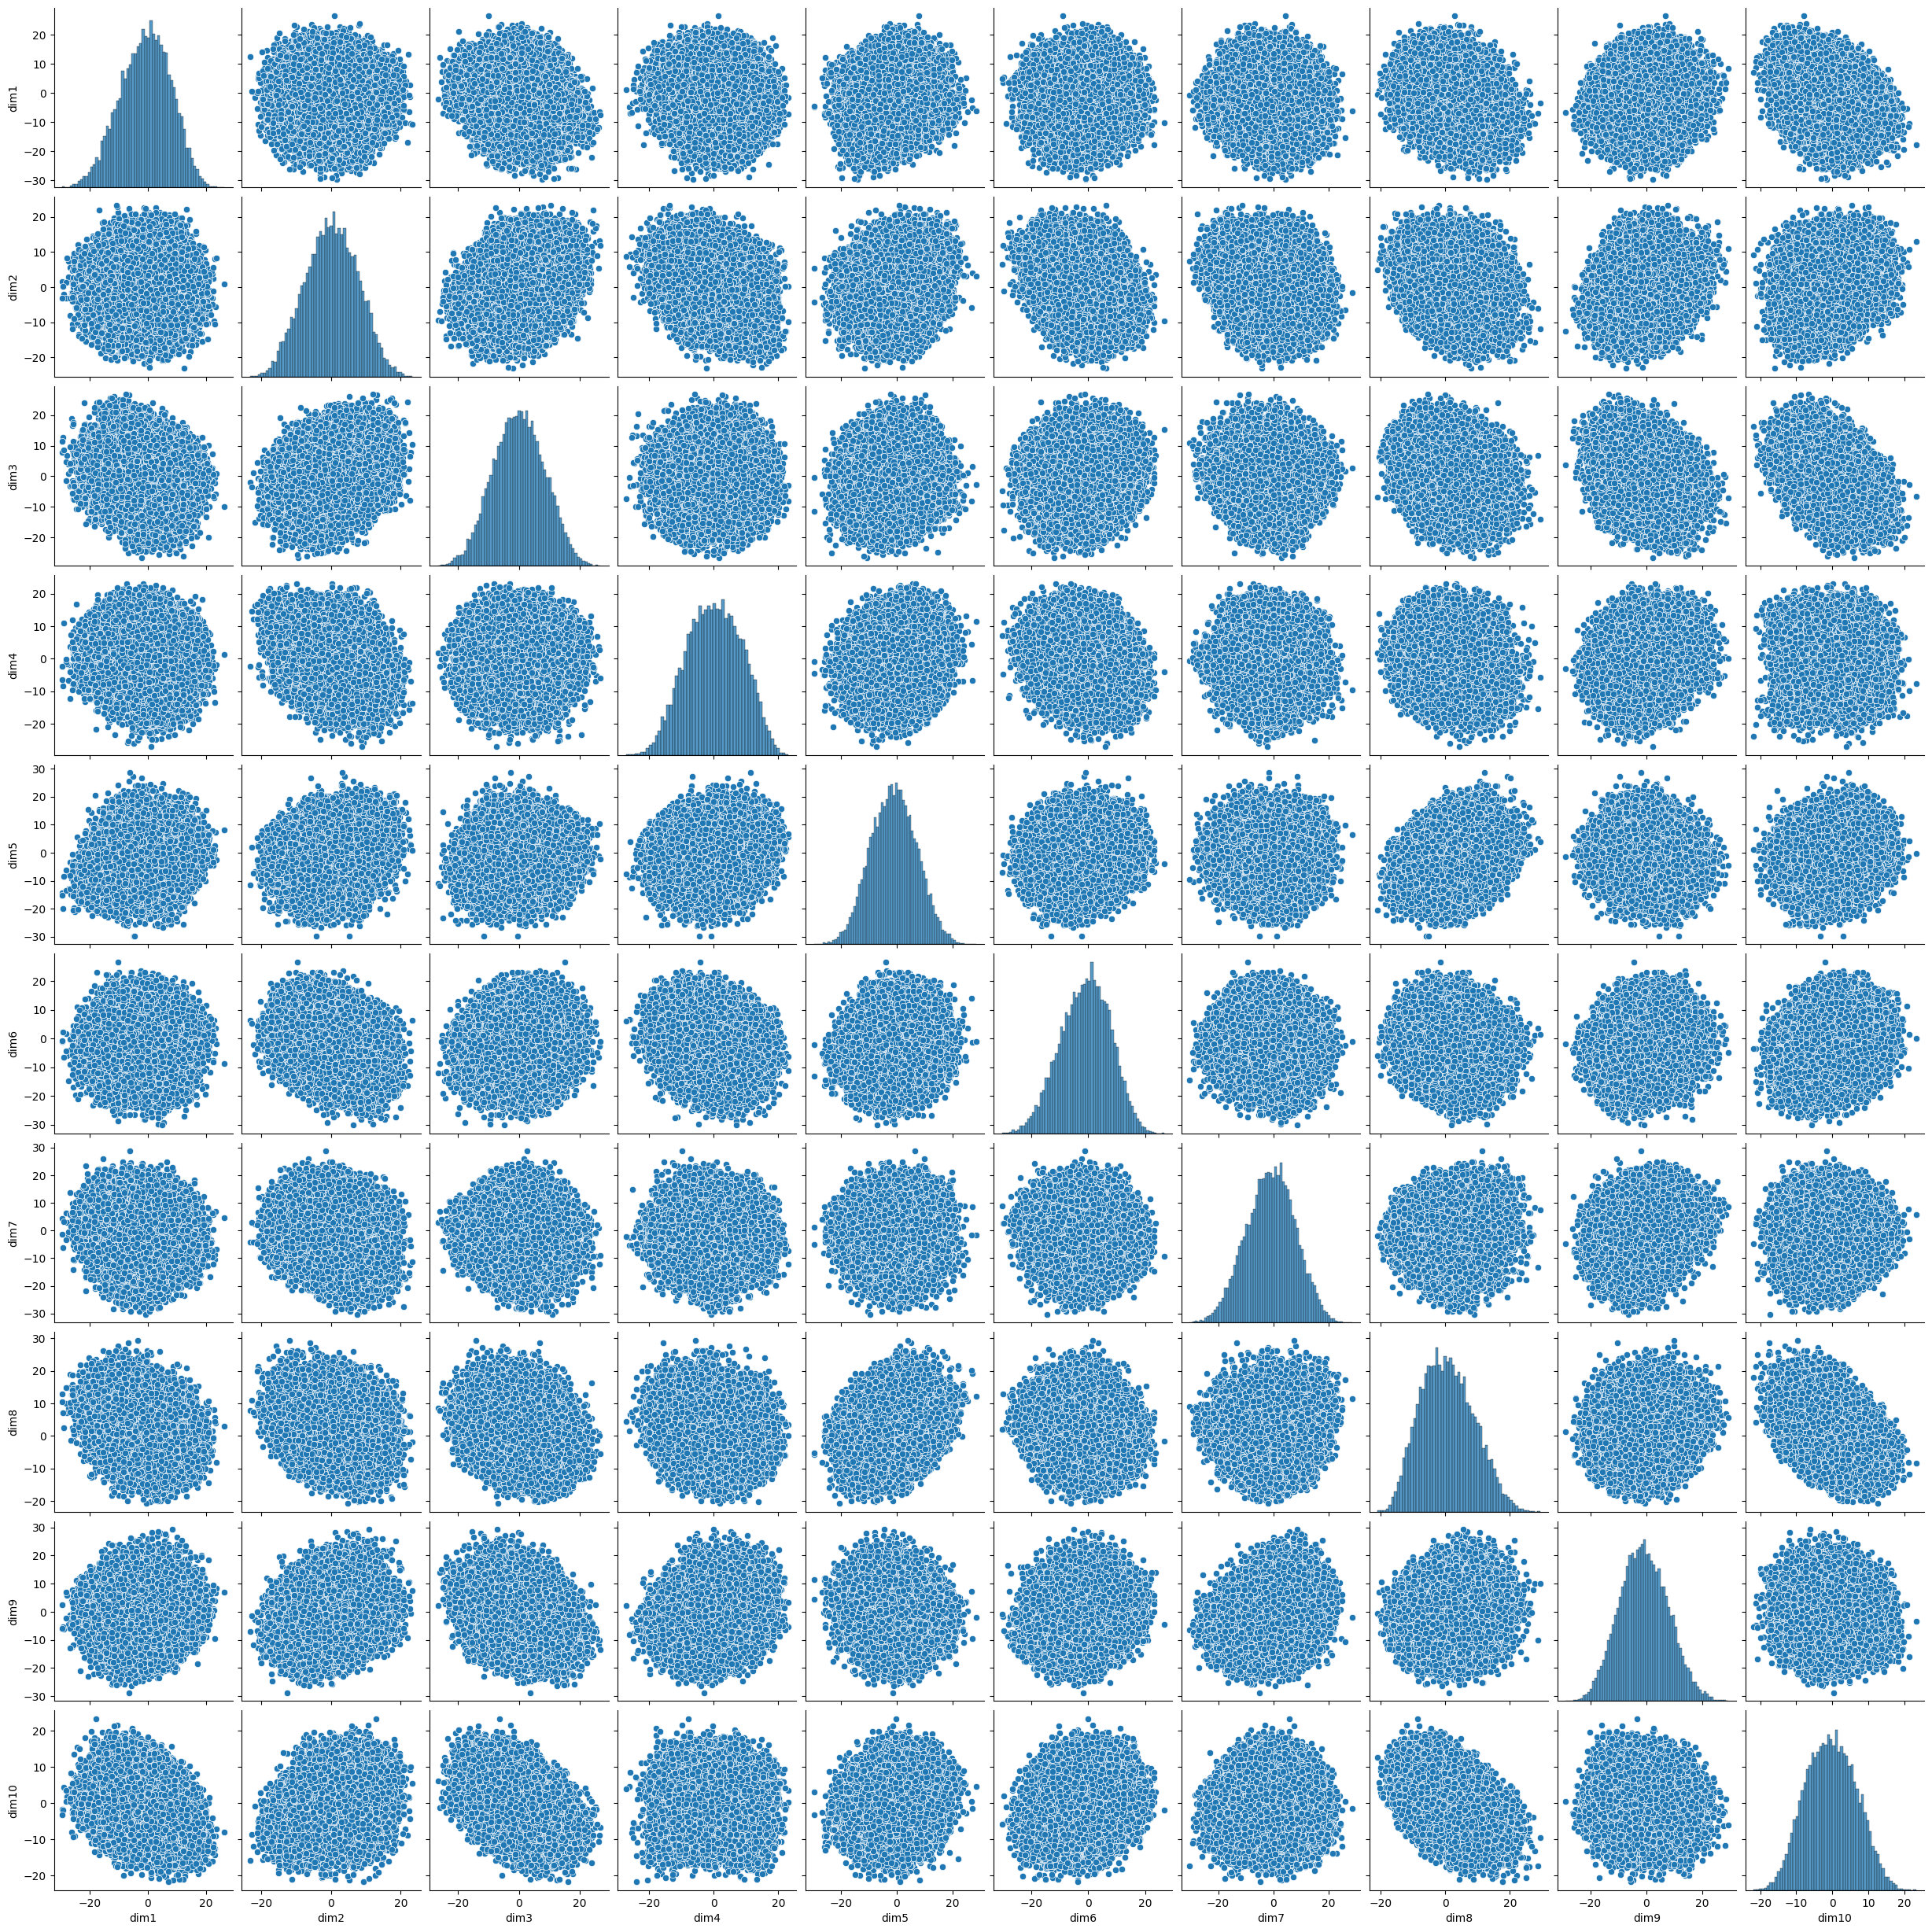

In [46]:
sns.pairplot(test_df)

## Visualize umap

In [7]:
def display_umaps_true_labels(visual_embs_train, reducer, test_df, prediction_df, verbose=False):
    if verbose:
        print("Test df:")
        print(test_df[:5])
        print("Prediction df:")
        print(prediction_df[:5])

    # apply umap
    if verbose:
        print("UMAP embeddings")
        print(visual_embs_train.shape)
        print(visual_embs_train[:5])
    visual_embs_test = reducer.transform(test_df)

    ## plot the graphs

    # plt.figure()
    # plt.scatter(visual_embs_train[:,0], visual_embs_train[:,1], c='green', alpha=0.4)

    # plot for true labels/volatile/jc225751/Runs/59_analysis_ukbiobank/Output/
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs_train[:,0], visual_embs_train[:,1], c=colors, s=1, alpha=0.6)
    plt.title("True labels")
    plt.show()
    
    plt.show()

    return pd.DataFrame(visual_embs_test, index=test_df.index.values)

In [8]:
def compute_umap(df, n_neighbors=15):
    # apply umap
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [9]:
len(third_df)

1113

# UMAP on UKBioBank

In [10]:
visual_embs, reducer = compute_umap(test_df, n_neighbors=100)

In [11]:
ukbiobank_embs = visual_embs.copy()

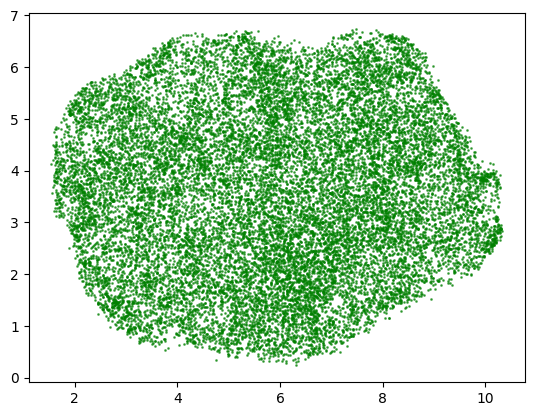

In [12]:
plt.scatter(visual_embs[:,0], visual_embs[:,1], c='g', s=1, alpha=0.6)

In [13]:
second_embs = reducer.transform(second_df)

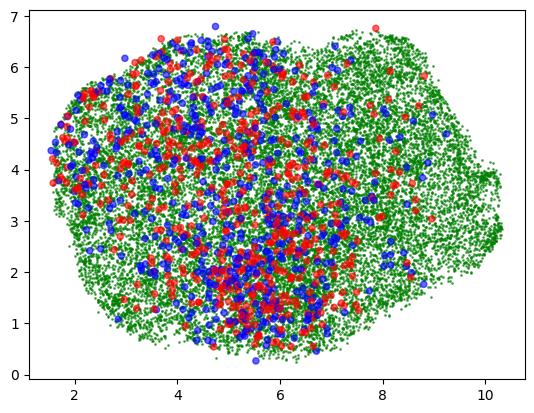

In [14]:
# plot for true labels
cmap = ['b', 'r']
colors = [cmap[i] for i in prediction_df.label]

plt.scatter(visual_embs[:,0], visual_embs[:,1], c='g', s=1, alpha=0.6)
plt.scatter(second_embs[:,0], second_embs[:,1], c=colors, s=20, alpha=0.6)

In [15]:
third_embs = reducer.transform(third_df)

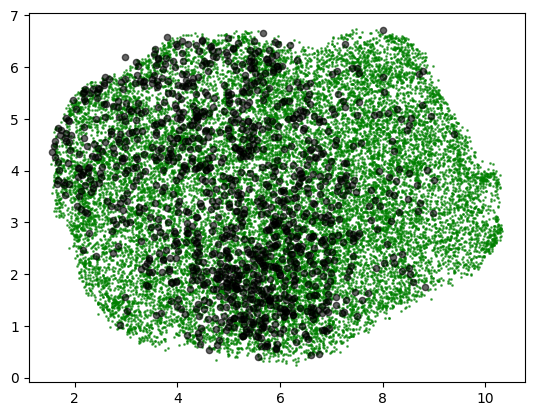

In [16]:
plt.scatter(visual_embs[:,0], visual_embs[:,1], c='g', s=1, alpha=0.6)
plt.scatter(third_embs[:,0], third_embs[:,1], c='black', s=20, alpha=0.6)

# UMAP on HCP

In [17]:
visual_embs, reducer = compute_umap(third_df, n_neighbors=15)

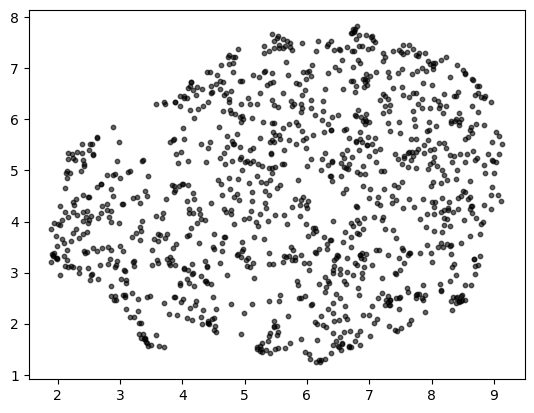

In [18]:
plt.scatter(visual_embs[:,0], visual_embs[:,1], c='black', s=10, alpha=0.6)

In [19]:
second_embs = reducer.transform(second_df)

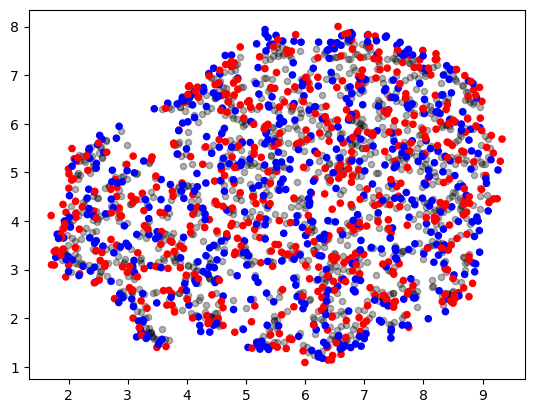

In [20]:
cmap = ['b', 'r']
colors = [cmap[i] for i in prediction_df.label]

plt.scatter(visual_embs[:,0], visual_embs[:,1], c='black', s=20, alpha=0.3)
plt.scatter(second_embs[:,0], second_embs[:,1], c=colors, s=20, alpha=1)

In [21]:
second_df.head()

dim1      dim2      dim3       dim4       dim5       dim6   
ID                                                                       
100206  -4.212993 -6.091548  0.684880  -4.523179 -22.484657  -5.401768  \
100307 -11.381368 -0.285900  4.927240  -6.655341 -12.707942   2.209926   
100408  -4.779641  3.934070  4.724153  13.620282   0.672553   6.630540   
100610  12.145811 -2.485927 -3.834115  -8.160861   1.870179   1.460827   
101006  12.997742 -5.642507  4.419470   4.485683   2.813657  13.278338   

             dim7      dim8       dim9     dim10  
ID                                                
100206   7.193287  0.370415  -0.450989 -5.523919  
100307   1.417610  8.749428   7.104042 -6.554472  
100408  -7.498280 -6.556977  11.008425  2.940426  
100610  12.370645 -0.535269  -0.761702 -1.108710  
101006   1.549488  0.472119  12.666688 -9.535495

In [22]:
third_embs = reducer.transform(test_df)

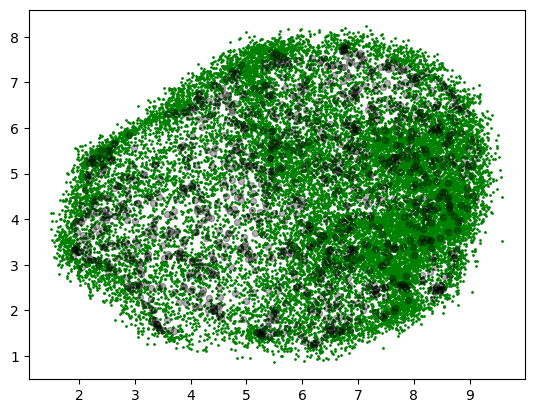

In [23]:
plt.scatter(third_embs[:,0], third_embs[:,1], c='green', s=1, alpha=1)
plt.scatter(visual_embs[:,0], visual_embs[:,1], c='black', s=20, alpha=0.3)

# Density map of UKBioBank

In [24]:
Z, xedges, yedges = np.histogram2d(ukbiobank_embs[:,0], ukbiobank_embs[:,1], bins=50, normed=True)

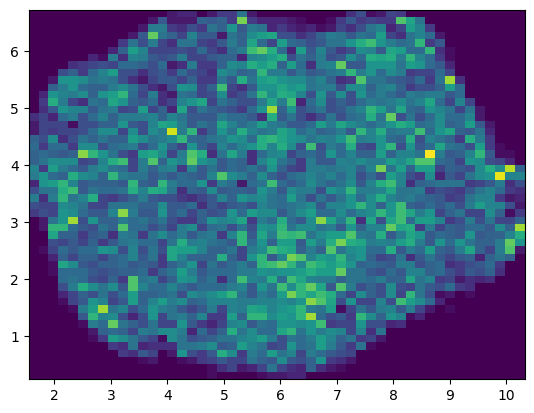

In [25]:
plt.pcolormesh(xedges, yedges, Z.T)

In [26]:
# fig, ax = plt.subplots(figsize=[15,8])
# plt.imshow(Z.T)

In [27]:
Z = Z/np.unique(Z)[1]

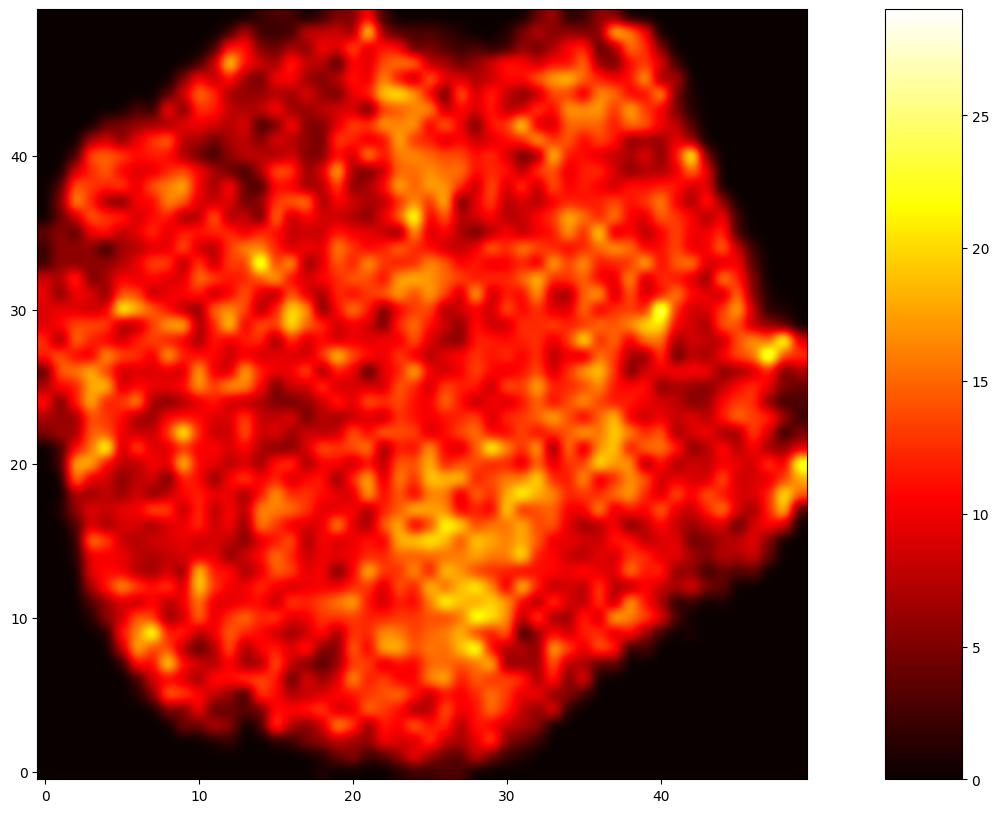

In [28]:
fig, ax = plt.subplots(figsize=[20,10])
cax = ax.imshow(Z.T,
          origin='lower',
          cmap='hot', 
          interpolation='gaussian'
          )
cbar   = fig.colorbar(cax,aspect=10)

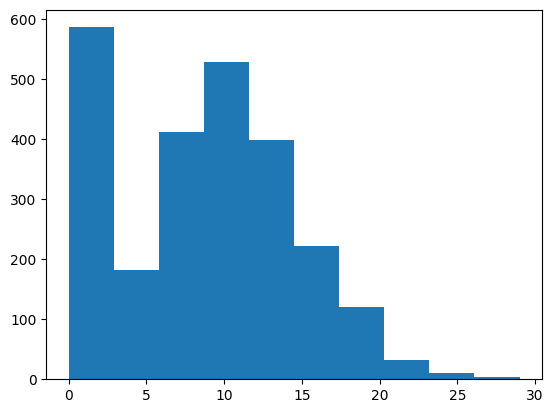

In [29]:
h = plt.hist(Z.reshape(Z.size,1), bins=10)

In [30]:
# import scipy.ndimage as ndi

In [31]:
# img = ndi.gaussian_filter(Z, (1,1))
# f, axs = plt.subplots(1, 1, figsize=(15, 15))
# plt.imshow(img)